In [1]:
!pip install pybbn

  Created wheel for pybbn: filename=pybbn-3.2.3-py3-none-any.whl size=40407 sha256=542522b734a3c57f6c63bdfe6925a6078e64a84f8cd2bc2a8e6f72e91dc6fcad
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\52\aa\29\604a0a26abba1522c308e6bae4a61f3b29f85240b50843d604
Successfully built pybbn


In [2]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [3]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
df=pd.read_csv('C:/Users/Admin/Machine Learning chapter 5/weatherAUS.csv', encoding='utf-8')
df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   
145459  2017-06-25    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0            NaN           W           44.0          W        WNW   
1            NaN         WNW           44.0        NNW        WSW   
2            NaN         WSW           46.0          W        WSW   
3            NaN          NE           24.0         SE          E   
4            NaN           W           41.0        ENE         NW   
...          ...         ...            ...        ...        ...   
145455       NaN           E           31.0         SE        ENE   
145456       NaN         NNW           22.0         SE          N   
145457       NaN           N           37.0         SE        WNW   
145458       NaN          SE           28.0        SSE          N   
145459       NaN         NaN            NaN        ESE        ESE   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
145455          13.0          11.0         51.0         24.0       1024.6   
145456          13.0           9.0         56.0         21.0       1023.5   
145457           9.0           9.0         53.0         24.0       1021.0   
145458          13.0           7.0         51.0         24.0       1019.4   
145459          17.0          17.0         62.0         36.0       1020.2   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
0            1007.1       8.0       NaN     16.9     21.8        No   
1            1007.8       NaN       NaN     17.2     24.3        No   
2            1008.7       NaN       2.0     21.0     23.2        No   
3            1012.8       NaN       NaN     18.1     26.5        No   
4            1006.0       7.0       8.0     17.8     29.7        No   
...             ...       ...       ...      ...      ...       ...   
145455       1020.3       NaN       NaN     10.1     22.4        No   
145456       1019.1       NaN       NaN     10.9     24.5        No   
145457       1016.8       NaN       NaN     12.5     26.1        No   
145458       1016.5       3.0       2.0     15.1     26.0        No   
145459       1017.9       8.0       8.0     15.0     20.9        No   

       RainTomorrow  
0                No  
1                No  
2                No  
3                No  
4                No  
...             ...  
145455           No  
145456           No  
145457           No  
145458           No  
145459          NaN  

[145460 rows x 23 columns]

In [4]:
# Drop records where target RainTomorrow=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]

# For other columns with missing values, fill them in with column mean
df=df.fillna(df.mean())

C:\Users\Admin\AppData\Local\Temp/ipykernel_31960/440301566.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=df.fillna(df.mean())


In [5]:
# Create bands for variables that we want to use in the model
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else
                                                            '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

In [6]:
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6     5.469824  7.624853   
1  2008-12-02   Albury      7.4     25.1       0.0     5.469824  7.624853   
2  2008-12-03   Albury     12.9     25.7       0.0     5.469824  7.624853   
3  2008-12-04   Albury      9.2     28.0       0.0     5.469824  7.624853   
4  2008-12-05   Albury     17.5     32.3       1.0     5.469824  7.624853   

  WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
0           W           44.0          W        WNW          20.0   
1         WNW           44.0        NNW        WSW           4.0   
2         WSW           46.0          W        WSW          19.0   
3          NE           24.0         SE          E          11.0   
4           W           41.0        ENE         NW           7.0   

   WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  \
0          24.0         71.0         22.0       1007.7       1007.1  8.000000   
1          22.0         44.0         25.0       1010.6       1007.8  4.437189   
2          26.0         38.0         30.0       1007.6       1008.7  4.437189   
3           9.0         45.0         16.0       1017.6       1012.8  4.437189   
4          20.0         82.0         33.0       1010.8       1006.0  7.000000   

   Cloud3pm  Temp9am  Temp3pm RainToday RainTomorrow WindGustSpeedCat  \
0  4.503167     16.9     21.8        No           No          1.40-50   
1  4.503167     17.2     24.3        No           No          1.40-50   
2  2.000000     21.0     23.2        No           No          1.40-50   
3  4.503167     18.1     26.5        No           No           0.<=40   
4  8.000000     17.8     29.7        No           No          1.40-50   

  Humidity9amCat Humidity3pmCat  
0          1.>60         0.<=60  
1         0.<=60         0.<=60  
2         0.<=60         0.<=60  
3         0.<=60         0.<=60  
4          1.>60         0.<=60

In [34]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [49]:
#Create nodes by using our earlier function to automatically calculate probabilities
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

# Create Network
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

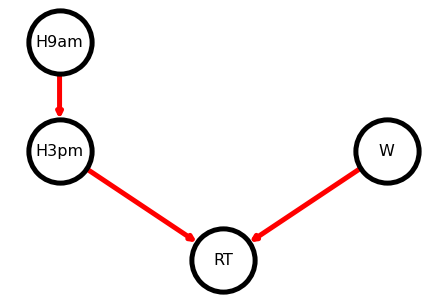

In [36]:

# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [46]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.67124
1=>60|0.32876
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.30658
0=>60|0.69342
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.77655
3=Yes|0.22345
----------------


# As you can see, this gives us the likelihood of each event occurring with a “Rain Tomorrow (RT)” probability of 22%.

# Said that the following step is where we get a lot of value out of our BBN. We can pass evidence into BBN and see how that affects probabilities for every node in the network.

# Example: 

# Let’s say it is 9 am right now, and we have measured the humidity outside. It says 72, which obviously belongs to the “>60” band. Hence, let’s pass this evidence into the BBN and see what happens. Note, I have created another small function to help us with that.

In [47]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)

In [48]:
# Use above function to add evidence
evidence('ev1', 'H9am', '>60', 1.0)

# Print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.55760
1=>60|0.44240
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.00000
0=>60|1.00000
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.73833
3=Yes|0.26167
----------------


# As you can see, “Humidity9am>60” is now equal to 100%, and the likelihood of “Humidity3pm>60” has increased from 32.8% to 44.2%. At the same time, the chance of “RainTomorrow” has gone up to 26.1%. Also, note how probabilities for “WindGustSpeed” did not change since “W” and “H9am” are independent of each other.

•Conditional Independence: D is considered conditionally independent of A. This is because as soon as we know whether event B has happened, A becomes irrelevant from the perspective of D. In other words, the following is true: P(D|B,A) = P(D|B).

# Second example: 

# To remove the first evidence rerun the 49 line. 

# After that, let’s pass two pieces of evidence for “H3pm” and “W.”: 

In [50]:
# Add more evidence
evidence('ev1', 'H3pm', '>60', 1.0)
evidence('ev2', 'W', '>50', 1.0)
# Print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.00000
1=>60|1.00000
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.06689
0=>60|0.93311
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.00000
2=40-50|0.00000
2=>50|1.00000
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.32182
3=Yes|0.67818
----------------


# Unsurprisingly, this tells us that the chance of rain tomorrow has gone up to 67.8%. Note how “H9am” probabilities also changed, which tells us that despite us only measuring humidity at 3 pm, we are 93% certain that humidity was also above 60 at 9 am this morning.